<a href="https://colab.research.google.com/github/Calberto76/Logistics-Python/blob/main/MC_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monte Carlo Simulation for Time Series Probabilistic Forecasting

Monte Carlo simulation is a computational technique used to model the behavior of complex systems. It generates random samples from probability distributions through the systems then analyzes the results. Monte Carlo simulation is applied across various fields including finance, engineering, physics, operations research, and all kinds of risk management. It is used extensively in time series to generate probabilistic predictions.

Let’s start with some fun facts. You may ask why it is called Monte Carlo. The name Monte Carlo is derived from the name of the city on a hill side of the mountain. Carlo is the Italian form of the name Charles, and Monte means mountain in Italian. Prince Charles III of Monaco ruled the principality from 1856 to 1889. The place is known for the Monte Carlo Casino.

It was 1940s, the time of World War II and the atomic bomb Manhattan project going on. Mathematicians Ulam and von Neumann were part of the Manhattan Project. They were interested in solving mathematical problems related to the behavior of neutrons in a nuclear chain reaction. However, the equations governing neutron diffusion were extremely complex and could not be solved analytically. To tackle these problems, Ulam and von Neumann realized that they could simulate neutron diffusion by using random numbers. They envisioned a simple game of solitaire played with cards at the Monte Carlo Casino. Therefore term Monte Carlo simulation was coined, and since then became a powerful computational technique.

The process of a Monte Carlo simulation basically goes like this:



1.   Define the model: First, you need to define the system or process you want to simulate including the equations and the parameters.
2.   Generate random samples: Then you generate random samples from the fitted probability distributions.
3.   Perform simulations: For each set of random samples, you run the model to simulate the behavior of the system.
4.   Analyze results: After running a large number of simulations, you analyze the results to understand the behavior of the system.

Now let’s demonstrate how it works. I will apply it to simulate future stock prices with two distributions: the Gaussian distribution and the Student’s t-distribution. These two distributions are commonly used by quantitative analysts for stock market data.

Here we load Apple’s daily stock prices from 2020 to 2024.

In [1]:
import yfinance as yf
orig = yf.download(["AAPL"], start="2020-01-01", end="2024-12-31")
orig = orig[('Adj Close')]
orig.tail()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2024-08-26,227.179993
2024-08-27,228.029999
2024-08-28,226.490005
2024-08-29,229.789993
2024-08-30,229.000000


With the price series we can calculate the simple daily returns and plot in a histogram.

<ipython-input-2-dfdc816493ed>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = orig[-1]


<Axes: >

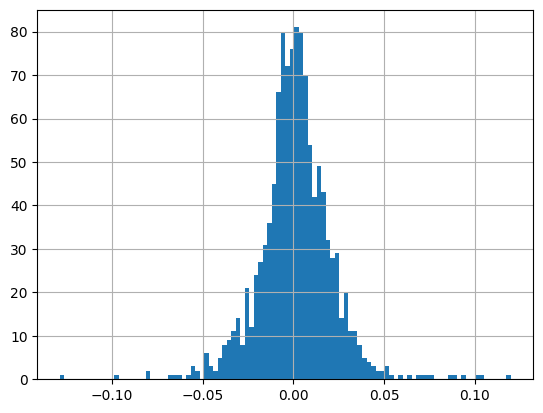

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
returns = orig.pct_change()
last_price = orig[-1]
returns.hist(bins=100)

Let’s fit it with a normal distribution.

(1) Fit the returns as a standard normal distribution

We will first calculate the historical volatility of the stock. This is typically done by computing the standard deviation of the stock’s daily returns. We assume the future volatility will be similar to the historical volatility.

The histogram looks like a normal distribution centering at 0.0. For simplicity, we assume this distribution is a Gaussian distribution with mean =0 and its standard deviation. Below we derive the standard deviation which is also called the daily volatility. Then the daily return % for tomorrow is expected to be a random value from the Gaussian distribution:

In [3]:
daily_volatility = returns.std()
rtn = np.random.normal(0, daily_volatility)

The next day price is today’s price multiplying by (1+return %):

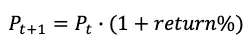


In [4]:
price = last_price * (1  + rtn)

The above are the basic financial formula for stock prices and returns. We are going to apply the MC simulation. To compute tomorrow’s price, we can randomly draw another return % to derive the day after tomorrow’s price. In this way we can derive a possible price path for the next, say, 200 days. This is just one of the possible price paths. We can repeat the same process to draw another price path. We will replicate this process 1,000 times to generate 1,000 price paths.

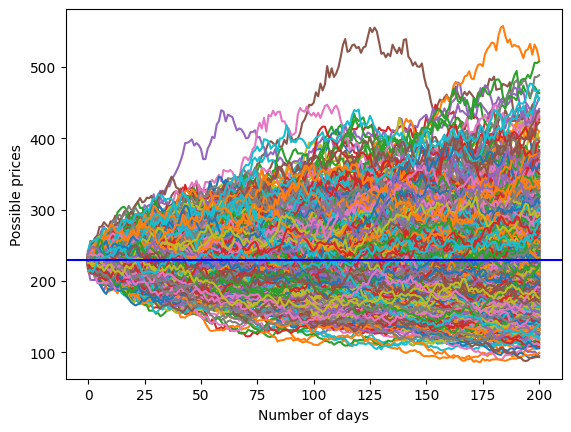

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

num_simulations = 1000
num_days = 200
simulation_df = pd.DataFrame()
for x in range(num_simulations):
    count = 0
    # The first price point
    price_series = []
    rtn = np.random.normal(0, daily_volatility)
    price = last_price * (1  + rtn)
    price_series.append(price)
    # Create each price path
    for g in range(num_days):
        rtn = np.random.normal(0, daily_volatility)
        price = price_series[g] * (1  + rtn)
        price_series.append(price)
    # Save all the possible price paths
    simulation_df[x] = price_series
fig = plt.figure()
plt.plot(simulation_df)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')
plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()

The result is the plot ready for analysis. The price starts at 179.66. Most of the price paths overlap with each other. The simulated price can be as high as  \$500 or as low as \$100.

And suppose we want to know the “normal” price range that will happen 90% of the time (between 5% and 95%), we can use quantile to get the upper and the lower bounds. With that, we can assess the extreme prices outside the upper bound and lower bound.

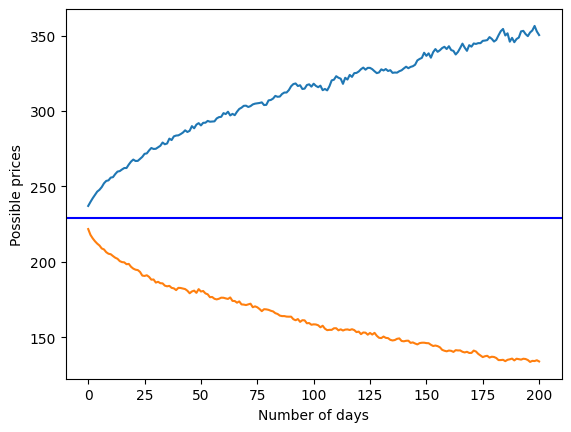

In [6]:
upper = simulation_df.quantile(.95, axis=1)
lower = simulation_df.quantile(.05, axis=1)
stock_range = pd.concat([upper, lower], axis=1)

fig = plt.figure()
plt.plot(stock_range)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')
plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()

Now let’s simulate with a Student’s t-distribution

Fit the returns as a Student’s t-distribution

Stock price returns are known to exhibit occasional extreme events. These extreme events locate the two sides of a distribution. A standard normal distribution expect 95% of the returns happening within two standard deviations and 5% outside the two standard deviations. If extreme events happen more often than 5%, the distribution will look “fatter”. This is what the statisticians called the fat tails because the distribution has fatter tails compared to the normal distribution. Because the distribution for stock price returns can exhibit fat tails, often quantitative analysts use the Student’s t-distribution to model stock price returns.

The Student’s t-distribution is characterized by three parameters:



*   The degrees of freedom parameter: It represents the number of independent observations in a sample used to estimate a population parameter. As the degrees of freedom increase, the t-distribution approaches the shape of the standard normal distribution (bell-shaped curve). The range of degrees of freedom for a Student’s t-distribution is any positive real number greater than 0. When df is small, the tails of the t-distribution are heavier, resembling a more fat-tailed distribution.
*   Scale: The scale parameter represents the spread or variability of the distribution. In the context of the t-distribution, the scale parameter is often the standard deviation of the population being sampled.
*   Location: The location parameter represents the location or center of the distribution. It is the mean of the population being sampled.

Let’s fit the actual stock returns with a Student’s t-distribution.



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

returns = orig.pct_change()

# Number of samples per simulation
num_samples = 100

# distribution fitting
returns = returns[1::] # Drop the first element, which is "NA"
params = t.fit(returns[1::]) # fit with a student-t

# Generate random numbers from Student's t-distribution
results = t.rvs(df=params[0], loc=params[1], scale=params[2], size=1000)
# Generate random numbers from Student's t-distribution
results = t.rvs(df=params[0], loc=params[1], scale=params[2], size=1000)
print('degree of freedom = ', params[0])
print('loc = ', params[1])
print('scale = ', params[2])

degree of freedom =  3.6566996622635033
loc =  0.0012388607714962346
scale =  0.014089558592631498


We will use these parameters to project a Student-t distribution. Then we will plot the actual stock return distribution with the Student-t distribution.

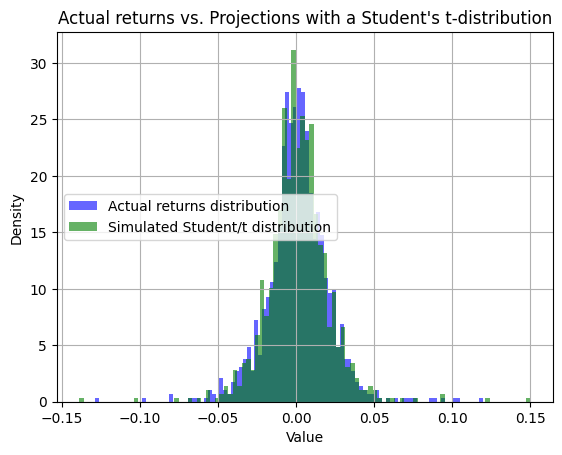

In [8]:
returns.hist(bins=100,density=True, alpha=0.6, color='b', label='Actual returns distribution')

# Plot histogram of results
plt.hist(results, bins=100, density=True, alpha=0.6, color='g', label='Simulated Student/t distribution')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Actual returns vs. Projections with a Student\'s t-distribution')
plt.legend(loc='center left')
plt.grid(True)
plt.show()

Like before, we will simulate the price paths for the next 200 days.

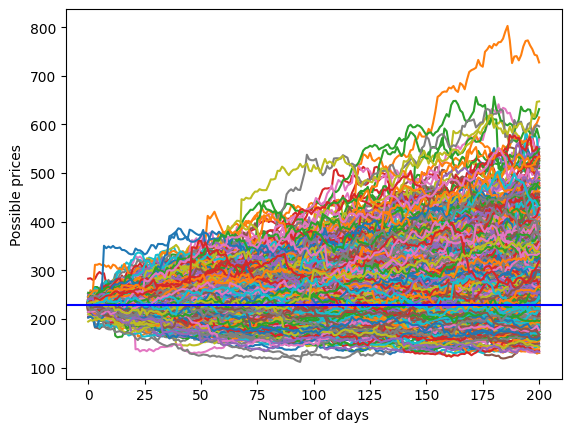

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

num_simulations = 1000
num_days = 200
simulation_student_t = pd.DataFrame()
for x in range(num_simulations):
    count = 0
    # The first price point
    price_series = []
    rtn = t.rvs(df=params[0], loc=params[1], scale=params[2], size=1)[0]
    price = last_price * (1  + rtn)
    price_series.append(price)
    # Create each price path
    for g in range(num_days):
        rtn = t.rvs(df=params[0], loc=params[1], scale=params[2], size=1)[0]
        price = price_series[g] * (1  + rtn)
        price_series.append(price)
    # Save all the possible price paths
    simulation_student_t[x] = price_series
fig = plt.figure()
plt.plot(simulation_student_t)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')
plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()

We can plot the upper bound at the 95% and the lower bound at the 5% confidence intervals for this Student-t Monte Carlo simulation:

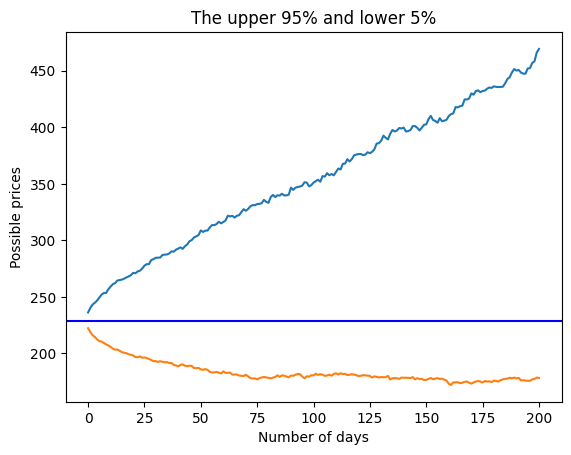

In [10]:
upper = simulation_student_t.quantile(.95, axis=1)
lower = simulation_student_t.quantile(.05, axis=1)
stock_range = pd.concat([upper, lower], axis=1)

fig = plt.figure()
plt.plot(stock_range)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')
plt.title('The upper 95% and lower 5%')
plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()

This notebbok performs two distributions applications that are commonly used in stock market data. We define the model, generate random samples, perform simulations, then analyze the results. The simulation technique helps us to generate probabilistic predictions and understand the potential risks.